The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.
Number of components is larger than 10 (421). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


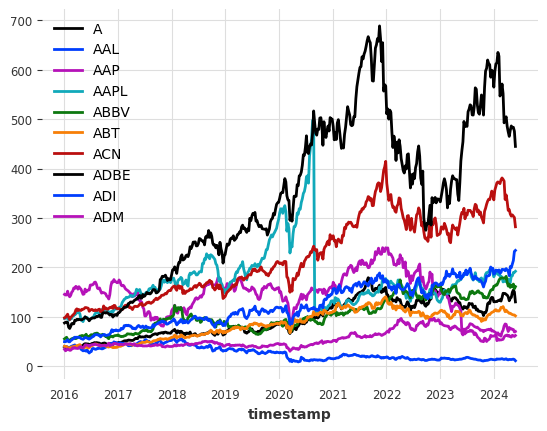

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import Scaler

closes = pd.read_csv('../raw_data/closes.csv', index_col='timestamp', parse_dates=True)
series = TimeSeries.from_dataframe(closes).astype(np.float32)
scaler = Scaler()
train, val = series.split_after(0.8)
train_scaled = scaler.fit_transform(train)
series.plot();

# N-BEATS

In [5]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=52, output_chunk_length=1, random_state=42)

model.fit(train_scaled, epochs=50, verbose=True);


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 178 M 
---------------------------------------------------
178 M     Trainable params
132 K     Non-trainable params
178 M     Total params
712.612   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Number of components is larger than 10 (421). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 10 (421). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


<Axes: xlabel='timestamp'>

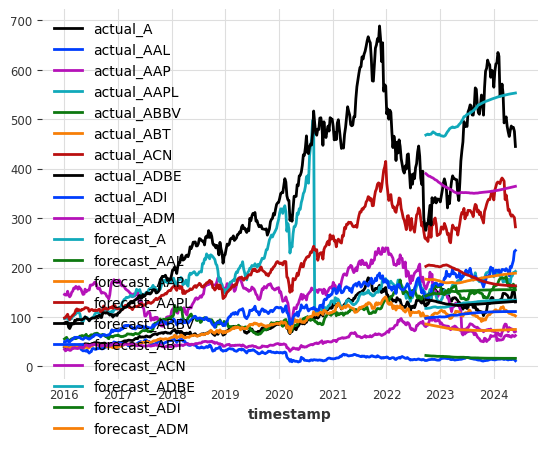

In [6]:
pred_series = model.predict(n=len(val), series=train_scaled)
pred_series = scaler.inverse_transform(pred_series)
series.plot(label='actual')
pred_series.plot(label='forecast', lw=2)

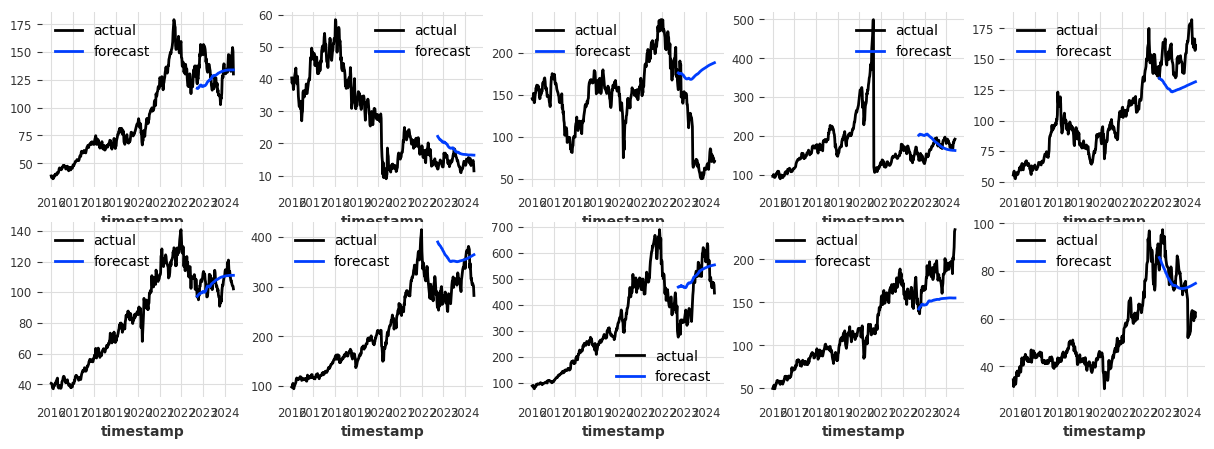

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for i, ax in enumerate(axs.ravel()):
    single_series = series.univariate_component(i)
    single_pred = pred_series.univariate_component(i)
    single_series.plot(label="actual", ax=ax)
    single_pred.plot(label="forecast", ax=ax);

## Evaluate

In [11]:
from darts.metrics import mape, mae

baseline_mae = np.mean(np.abs(val.values() - train[-1].values()))
print(f'Baseline MAE: {baseline_mae:.5f}')
print(f'MAPE: {mape(val, pred_series):.2f}%')
print(f'MAE: {mae(val, pred_series):.5f}')

Baseline MAE: 33.08684
MAPE: 34.51%
MAE: 46.21574


# RNN

In [12]:
from darts.models import RNNModel

model = RNNModel(
    input_chunk_length=24,
    model='LSTM',
    hidden_dim=20,
    n_rnn_layers=2,
    #training_length=52,
)

model.fit(train_scaled, verbose=True, epochs=25)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 38.8 K
4 | V             | Linear           | 8.8 K 
---------------------------------------------------
47.6 K    Trainable params
0         Non-trainable params
47.6 K    Total params
0.191     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, dropout=0.0, training_length=24, input_chunk_length=24)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Number of components is larger than 10 (421). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.
Number of components is larger than 10 (421). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


<Axes: xlabel='timestamp'>

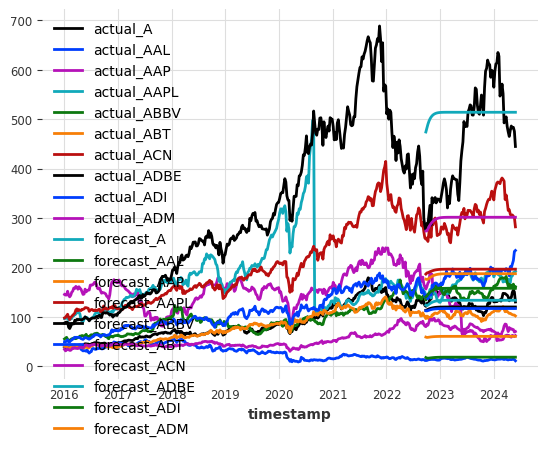

In [13]:
pred_series = model.predict(n=len(val))
pred_series = scaler.inverse_transform(pred_series)
series.plot(label='actual')
pred_series.plot(label='forecast', lw=2)

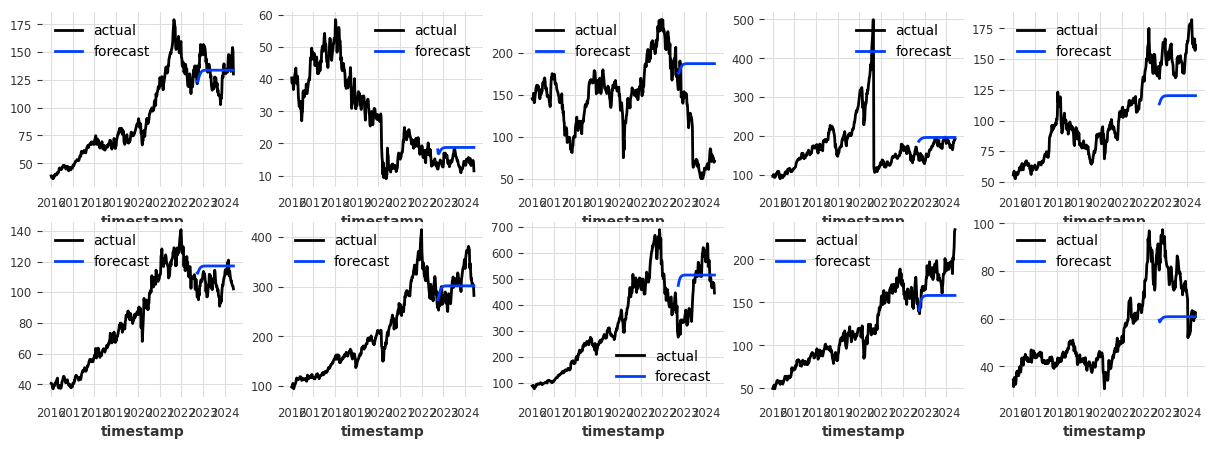

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for i, ax in enumerate(axs.ravel()):
    single_series = series.univariate_component(i)
    single_pred = pred_series.univariate_component(i)
    single_series.plot(label="actual", ax=ax)
    single_pred.plot(label="forecast", ax=ax);

In [15]:
from darts.metrics import mape, mae

baseline_mae = np.mean(np.abs(val.values() - train[-1].values()))
print(f'Baseline MAE: {baseline_mae:.5f}')
print(f'MAPE: {mape(val, pred_series):.2f}%')
print(f'MAE: {mae(val, pred_series):.5f}')

Baseline MAE: 33.08684
MAPE: 42.82%
MAE: 56.83470
